In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Activation, Add,DepthwiseConv2D, BatchNormalization, Concatenate, Conv2D, Dense,Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda,LeakyReLU, MaxPooling2D, Multiply, Permute, Reshape, UpSampling2D
import collections
import tensorflow as tf
from tensorflow.keras import regularizers
from  tensorflow.keras.initializers import *
# from keras_flops import get_flops

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path = '/content/drive/MyDrive/deep learning/Training/'
val_path = '/content/drive/MyDrive/deep learning/Validation/'
test_path = '/content/drive/MyDrive/deep learning/Test/'
batch_size = 4
img_height = 224
img_width = 224
no_of_classes = 5
classes_name = [0,1,2,3,4]
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    horizontal_flip = False,
    vertical_flip = False,
    #validation_split = 0.1,
    featurewise_std_normalization=True)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
     target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')


print(train_generator.class_indices)

Found 3432 images belonging to 5 classes.
Found 503 images belonging to 5 classes.
{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3, 'grade4': 4}


In [ ]:
def se_block(block_input, num_filters, ratio=8):

	pool1 = tf.keras.layers.GlobalAveragePooling2D()(block_input)
	flat = tf.keras.layers.Reshape((1, 1, num_filters))(pool1)
	dense1 = tf.keras.layers.Dense(num_filters//ratio, activation='relu')(flat)
	dense2 = tf.keras.layers.Dense(num_filters, activation='sigmoid')(dense1)
	scale = tf.keras.layers.multiply([block_input, dense2])

	return scale


def resnet_block(block_input, num_filters):

	if tf.keras.backend.int_shape(block_input)[3] != num_filters:
		block_input = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1))(block_input)

	conv1 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same')(block_input)
	norm1 = tf.keras.layers.BatchNormalization()(conv1)
	relu1 = tf.keras.layers.Activation('relu')(norm1)
	conv2 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), padding='same')(relu1)
	norm2 = tf.keras.layers.BatchNormalization()(conv2)

	se = se_block(norm2, num_filters=num_filters)

	sum = tf.keras.layers.Add()([block_input, se])
	relu2 = tf.keras.layers.Activation('relu')(sum)

	return relu2

def se_resnet14():

  input = tf.keras.layers.Input(shape=(224, 224, 3))
  conv1 = tf.keras.layers.Conv2D(16, kernel_size=(7, 7), activation='relu', padding='same', kernel_initializer='he_normal')(input)

  block1 = resnet_block(conv1, 16)
  block2 = resnet_block(block1, 16)
  block3 = resnet_block(block2,16)

  pool1 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block3)

  block4 = resnet_block(pool1, 32)
  block5 = resnet_block(block4, 32)
  block6 = resnet_block(block5,32)

  pool2 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block6)

  block7 = resnet_block(pool2, 64)
  block8 = resnet_block(block7, 64)
  block9 = resnet_block(block8,64)

  global_pool = tf.keras.layers.GlobalAveragePooling2D()(block9)

  output = tf.keras.layers.Dense(5, activation='softmax')(global_pool)

  model = tf.keras.models.Model(inputs=input, outputs=output)
  return model


In [ ]:

# adam = tf.keras.optimizers.Adam(lr = 0.0001)
model_se = se_resnet14()
model_se.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ["acc"])
model_se.summary()
# flops = get_flops(model_se,batch_size=1)
# print(f"Flops:{flops/10**9:.03}G")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         2368      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 16)         64        ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=40, verbose=1,
                                              mode = 'max', restore_best_weights = True)
# check_path = 'E:/Grading_Files/comp/new_work_BHC_222.h5'
check_path = 'E:/Grading_Files/comp/new_work_BHC_22222222.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(check_path, monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')


history = model_se.fit_generator(train_generator , validation_data = validation_generator ,
                                  steps_per_epoch= len(train_generator) ,
                                  validation_steps = len(validation_generator)
                                  ,epochs = 70,callbacks = [reduce_lr, early_stop, checkpoint] )
# model_prop.load_weights('/content/drive/MyDrive/Major_project_data/Kidney_KMC/KMC_kidney_40x_dataset/Metrics/checkpoint_anirudh_7.h5')

<ipython-input-6-0485852a0fb2>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_se.fit_generator(train_generator , validation_data = validation_generator ,
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/70
858/858 [==============================] - ETA: 0s - loss: 1.1430 - acc: 0.5291
Epoch 1: val_acc improved from -inf to 0.20875, saving model to E:/Grading_Files/comp/new_work_BHC_22222222.h5
858/858 [==============================] - 2244s 3s/step - loss: 1.1430 - acc: 0.5291 - val_loss: 3.5655 - val_acc: 0.2087 - lr: 0.0010
Epoch 2/70
858/858 [==============================] - ETA: 0s - loss: 0.9249 - acc: 0.6416
Epoch 2: val_acc improved from 0.20875 to 0.54076, saving model to E:/Grading_Files/comp/new_work_BHC_22222222.h5
858/858 [==============================] - 2041s 2s/step - loss: 0.9249 - acc: 0.6416 - val_loss: 1.4148 - val_acc: 0.5408 - lr: 0.0010
Epoch 3/70
858/858 [==============================] - ETA: 0s - loss: 0.8284 - acc: 0.6780
Epoch 3: val_acc did not improve from 0.54076
858/858 [==============================] - 2053s 2s/step - loss: 0.8284 - acc: 0.6780 - val_loss: 35.8288 - val_acc: 0.2465 - lr: 0.0010
Epoch 4/70
858/858 [===========================

In [ ]:
model_se.load_weights('E:/Grading_Files/comp/new_work_BHC_22222222.h5')

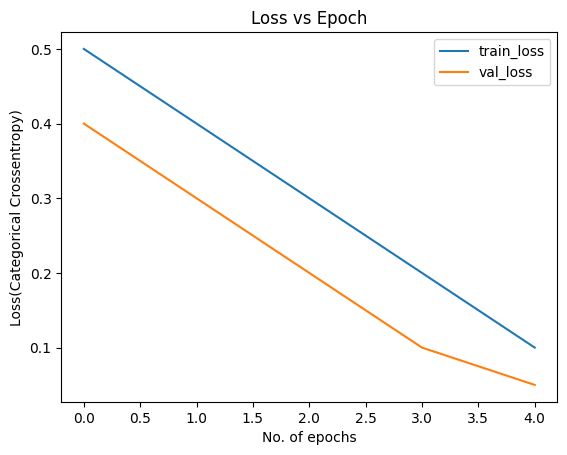

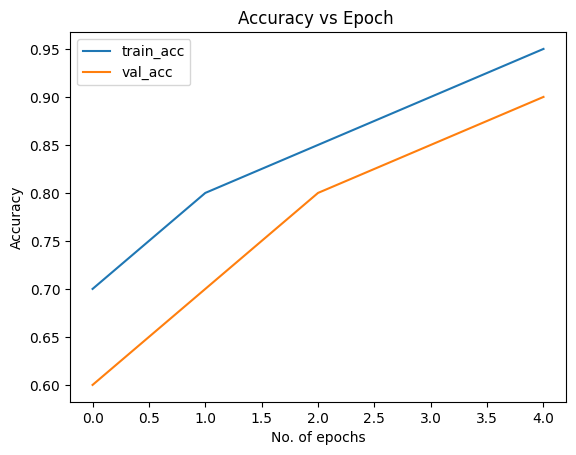

In [ ]:
import matplotlib.pyplot as plt
a = {
    'loss': [0.5, 0.4, 0.3, 0.2, 0.1],
    'val_loss': [0.4, 0.3, 0.2, 0.1, 0.05],
    'acc': [0.7, 0.8, 0.85, 0.9, 0.95],
    'val_acc': [0.6, 0.7, 0.8, 0.85, 0.9]
}

plt.plot(a['loss'] , label = 'train_loss')
plt.plot(a['val_loss'] , label = 'val_loss')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Loss(Categorical Crossentropy)")
plt.title("Loss vs Epoch")
# plt.savefig('E:/Grading_Files/comp/plot/graph/91.69-Loss.png',bbox_inches='tight')
plt.show()
plt.plot(a['acc'] , label = 'train_acc')
plt.plot(a['val_acc'] , label = 'val_acc')
plt.legend()
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch ")
# plt.savefig('E:/Grading_Files/comp/plot/graph/91.69-ACC.png',bbox_inches='tight')
plt.show()

In [ ]:
test_d = ImageDataGenerator(rescale=1. / 255)
test = test_d.flow_from_directory('/content/drive/MyDrive/deep learning/Test',target_size=(224,224),batch_size=1,shuffle = False,class_mode='categorical')

Found 142 images belonging to 5 classes.


In [ ]:
import numpy as np
test_step = test.n//test.batch_size
test.reset()
pred = model_se.predict_generator(test , steps = test_step , verbose = 1)
pred_class_indices = np.argmax(pred,axis=1)

## printing predicted labels
print(pred_class_indices)

<ipython-input-48-0160d172a31d>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model_se.predict_generator(test , steps = test_step , verbose = 1)


142/142 [==============================] - 38s 257ms/step
[0 0 0 0 0 0 0 0 0 4 4 0 4 0 0 0 0 4 0 0 4 0 0 0 0 0 0 0 0 4 4 0 1 0 0 4 0
 0 0 4 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 0 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 4 4 4 4 4 4]


In [ ]:
from sklearn.metrics import *
classes = [0,1,2,3,4]


for cl in classes:

    print("class: ",cl)

    a1 = np.uint8(test.labels == cl)
    a2 = np.uint8(pred_class_indices == cl)

    print('Accuracy {}'.format(accuracy_score(y_true=a1, y_pred=a2)))
    print('F1 {}'.format(f1_score(y_true=a1, y_pred=a2)))
    print('precision {}'.format(precision_score(y_true=a1, y_pred=a2)))
    print('recall {}'.format(recall_score(y_true=a1, y_pred=a2)))

    print('jaccard {}'.format(jaccard_score(y_true=a1, y_pred=a2)))
    print("_______________________________")

class:  0
Accuracy 0.9225352112676056
F1 0.8493150684931506
precision 0.96875
recall 0.7560975609756098
jaccard 0.7380952380952381
_______________________________
class:  1
Accuracy 0.9859154929577465
F1 0.9642857142857143
precision 0.9310344827586207
recall 1.0
jaccard 0.9310344827586207
_______________________________
class:  2
Accuracy 0.9577464788732394
F1 0.8636363636363636
precision 1.0
recall 0.76
jaccard 0.76
_______________________________
class:  3
Accuracy 0.9507042253521126
F1 0.8510638297872339
precision 0.7692307692307693
recall 0.9523809523809523
jaccard 0.7407407407407407
_______________________________
class:  4
Accuracy 0.9154929577464789
F1 0.8125000000000001
precision 0.7222222222222222
recall 0.9285714285714286
jaccard 0.6842105263157895
_______________________________


In [ ]:
print('Accuracy {}'.format(accuracy_score(y_true=test.labels, y_pred=pred_class_indices)))
print('F1 {}'.format(f1_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('precision {}'.format(precision_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('recall {}'.format(recall_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))

print('jaccard {}'.format(jaccard_score(y_true=test.labels, y_pred=pred_class_indices,average = "macro")))
print('confusion_matrix\n {}'.format(confusion_matrix(y_true=test.labels, y_pred=pred_class_indices)))
print('classification_report\n {}'.format(classification_report(y_true=test.labels, y_pred=pred_class_indices)))
print('\n\n')

Accuracy 0.8661971830985915
F1 0.8681601952404925
precision 0.8782474948423223
recall 0.8794099883855981
jaccard 0.7708161975820778
confusion_matrix
 [[31  1  0  0  9]
 [ 0 27  0  0  0]
 [ 1  1 19  4  0]
 [ 0  0  0 20  1]
 [ 0  0  0  2 26]]
classification_report
               precision    recall  f1-score   support

           0       0.97      0.76      0.85        41
           1       0.93      1.00      0.96        27
           2       1.00      0.76      0.86        25
           3       0.77      0.95      0.85        21
           4       0.72      0.93      0.81        28

    accuracy                           0.87       142
   macro avg       0.88      0.88      0.87       142
weighted avg       0.89      0.87      0.87       142




